In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from DistanceMetrics import InstanceDistanceMetrics
from DistanceMetrics import PersonDistanceMetricsNoOrdering
from DistanceMetrics import PersonDistanceMetricsOrdering
from Clustering import NonHierarchicalClustering
from Clustering import HierarchicalClustering
import util.util as util
from util.VisualizeDataset import VisualizeDataset

import sys
import copy

from pathlib import Path

In [3]:
def plot_clusters_3d(data_table, data_cols, cluster_col, label_cols):
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    
    color_index = 0
    point_displays = ['+', 'x', '*', 'd', 'o', 's', '<', '>']

    # Determine the number of clusters:
    clusters = data_table[cluster_col].unique()
    labels = []

    # Get the possible labels, assuming 1 or more label columns with binary values.
    for i in range(0, len(label_cols)):
        labels.extend([name for name in list(data_table.columns) if label_cols[i] == name[0:len(label_cols[i])]])

    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')
    handles = []

    # Plot clusters individually with a certain color.
    for cluster in clusters:
        marker_index = 0
        
        # And make sure the points of a label receive the right marker type.
        for label in labels:
            rows = data_table.loc[(data_table[cluster_col] == cluster) & (data_table[label] > 0)]
            # Now we come to the assumption that there are three data_cols specified:
            if not len(data_cols) == 3:
                return
            plot_color = colors[color_index % len(colors)]
            plot_marker = point_displays[marker_index % len(point_displays)]
            pt = ax.scatter(rows[data_cols[0]], rows[data_cols[1]], rows[data_cols[2]], c=plot_color, marker=plot_marker)
            if color_index == 0:
                handles.append(pt)
            ax.set_xlabel(data_cols[0])
            ax.set_ylabel(data_cols[1])
            ax.set_zlabel(data_cols[2])
            marker_index += 1
        color_index += 1

    plt.legend(handles, labels, fontsize='xx-large', numpoints=1)
    plt.savefig("clusters.png")
    plt.show()

===== kmeans clustering =====
silhouette for k = 2: 0.4262282379946944
silhouette for k = 3: 0.5348162447516348
silhouette for k = 4: 0.6356394712656175
silhouette for k = 5: 0.6810104947521859
silhouette for k = 6: 0.7425841388574435
silhouette for k = 7: 0.740001874212922
silhouette for k = 8: 0.7371953287469925
silhouette for k = 9: 0.7096200090818573
Figure saved to figures/figure_1.png


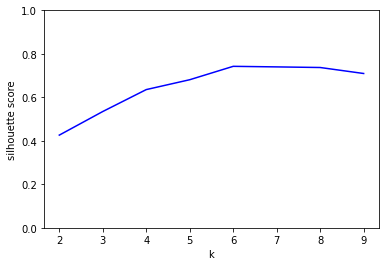

Highest K-Means silhouette score: k = 6


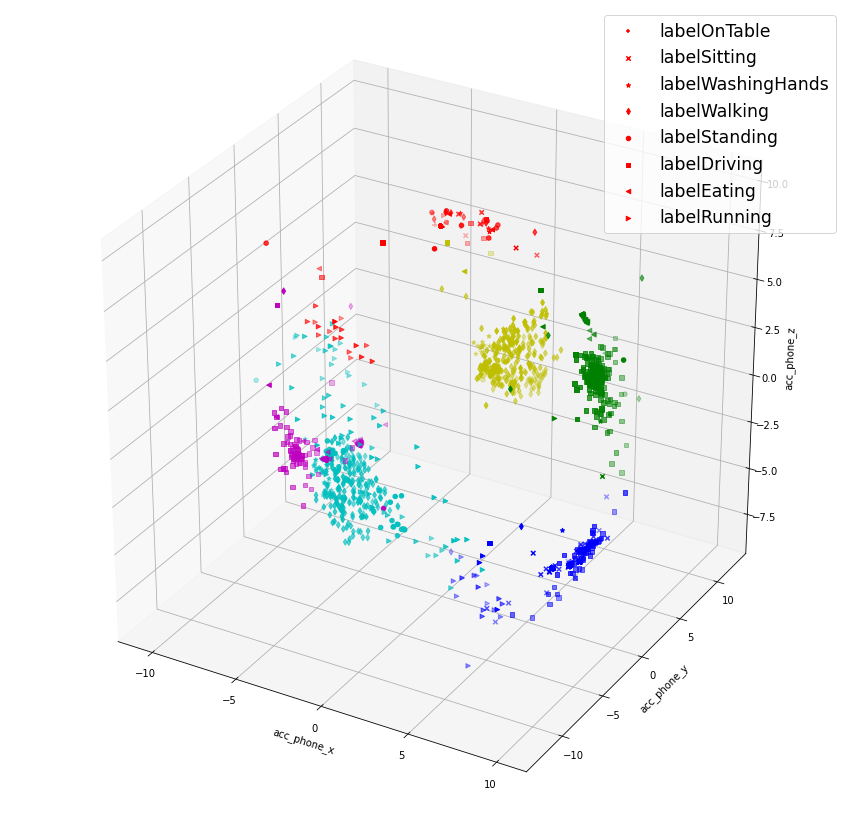

Figure saved to figures/figure_2.png


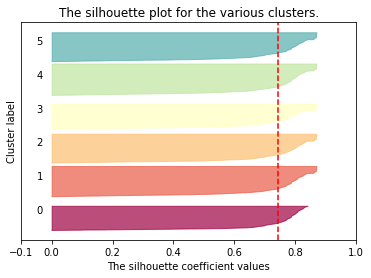

\multirow{2}{*}{ acc_phone_x } & mean  &  -0.36 &  8.24 &  8.00 &  -0.75 &  -8.21 &  -0.56\\
 & std  &  1.15 &  0.96 &  1.02 &  1.71 &  0.94 &  1.21\\
\multirow{2}{*}{ acc_phone_y } & mean  &  0.98 &  0.61 &  -2.35 &  -9.61 &  2.25 &  9.55\\
 & std  &  1.92 &  1.36 &  2.06 &  1.22 &  1.94 &  1.12\\
\multirow{2}{*}{ acc_phone_z } & mean  &  9.19 &  4.54 &  -4.80 &  0.23 &  -4.67 &  -0.56\\
 & std  &  1.06 &  1.36 &  1.08 &  1.49 &  1.44 &  1.62\\
labelOnTable  & percentage  &  99.56 \% &  0.44 \% &  0.00 \% &  0.00 \% &  0.00 \% &  0.00 \%\\
labelSitting  & percentage  &  2.40 \% &  0.40 \% &  97.20 \% &  0.00 \% &  0.00 \% &  0.00 \%\\
labelWashingHands  & percentage  &  7.02 \% &  1.75 \% &  1.75 \% &  56.14 \% &  0.00 \% &  33.33 \%\\
labelWalking  & percentage  &  1.87 \% &  0.94 \% &  0.47 \% &  46.14 \% &  0.47 \% &  50.12 \%\\
labelStanding  & percentage  &  4.74 \% &  1.42 \% &  0.00 \% &  48.34 \% &  0.47 \% &  45.02 \%\\
labelDriving  & percentage  &  1.67 \% &  55.56 \% &  20

In [4]:
# As usual, we set our program constants, read the input file and initialize a visualization object.
DATA_PATH = Path('../crowdsignals/')
DATASET_FNAME = 'chapter4_result.csv'
RESULT_FNAME = 'chapter5_result.csv'

try:
    dataset = pd.read_csv(DATA_PATH / DATASET_FNAME, index_col=0)
    dataset.index = pd.to_datetime(dataset.index)
except IOError as e:
    print('File not found, try to run previous crowdsignals scripts first!')
    raise e

DataViz = VisualizeDataset()

# We'll start by applying non-hierarchical clustering.
clusteringNH = NonHierarchicalClustering()

# Let us look at k-means first.
k_values = range(2, 10)
silhouette_values = []

## Do some initial runs to determine the right number for k

print('===== kmeans clustering =====')
for k in k_values:

    dataset_cluster = clusteringNH.k_means_over_instances(copy.deepcopy(dataset), ['acc_phone_x', 'acc_phone_y', 'acc_phone_z'], k, 'default', 20, 10)
    silhouette_score = dataset_cluster['silhouette'].mean()
    print(f'silhouette for k = {k}: {silhouette_score}')
    silhouette_values.append(silhouette_score)

DataViz.plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score',
                ylim=[0,1], line_styles=['b-'])

# And run the knn with the highest silhouette score

# k = 6 # todo: replaced with np.argmax call over silhouette scores
k = k_values[np.argmax(silhouette_values)]
print(f'Highest K-Means silhouette score: k = {k}')

dataset_knn = clusteringNH.k_means_over_instances(copy.deepcopy(dataset), ['acc_phone_x', 'acc_phone_y', 'acc_phone_z'], k, 'default', 50, 50)
plot_clusters_3d(dataset_knn, ['acc_phone_x', 'acc_phone_y', 'acc_phone_z'], 'cluster', ['label'])
DataViz.plot_silhouette(dataset_knn, 'cluster', 'silhouette')
util.print_latex_statistics_clusters(dataset_knn, 'cluster', ['acc_phone_x', 'acc_phone_y', 'acc_phone_z'], 'label')

### Again for the gyroscope data

===== kmeans clustering =====
silhouette for k = 2: 0.6516851950601088
silhouette for k = 3: 0.6533601223162748
silhouette for k = 4: 0.6743770786725156
silhouette for k = 5: 0.68482023591259
silhouette for k = 6: 0.6684133442086586
silhouette for k = 7: 0.652298745924865
silhouette for k = 8: 0.6565540404029988
silhouette for k = 9: 0.655344091456949
Figure saved to figures/figure_1.png


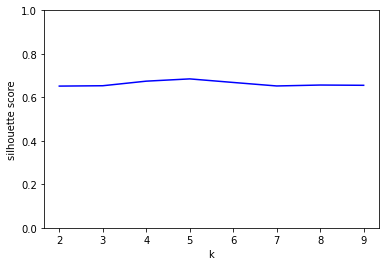

Highest K-Means silhouette score: k = 5


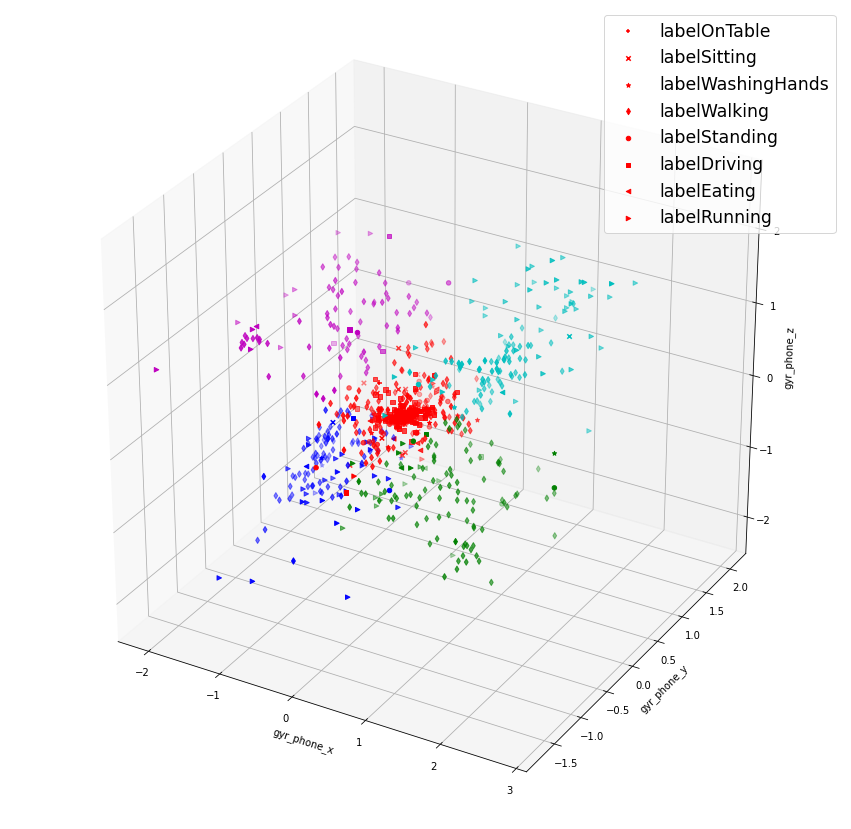

Figure saved to figures/figure_2.png


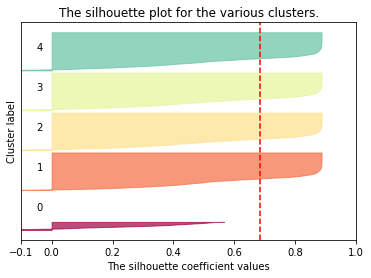

\multirow{2}{*}{ gyr_phone_x } & mean  &  -0.01 &  0.80 &  -0.91 &  1.17 &  -1.09\\
 & std  &  0.15 &  0.43 &  0.39 &  0.42 &  0.43\\
\multirow{2}{*}{ gyr_phone_y } & mean  &  0.04 &  -0.37 &  -0.14 &  0.31 &  0.16\\
 & std  &  0.22 &  0.59 &  0.51 &  0.56 &  0.58\\
\multirow{2}{*}{ gyr_phone_z } & mean  &  0.01 &  -0.50 &  -0.83 &  1.02 &  0.80\\
 & std  &  0.12 &  0.47 &  0.41 &  0.47 &  0.33\\
labelOnTable  & percentage  &  100.00 \% &  0.00 \% &  0.00 \% &  0.00 \% &  0.00 \%\\
labelSitting  & percentage  &  98.80 \% &  0.00 \% &  0.80 \% &  0.40 \% &  0.00 \%\\
labelWashingHands  & percentage  &  91.23 \% &  1.75 \% &  5.26 \% &  1.75 \% &  0.00 \%\\
labelWalking  & percentage  &  28.57 \% &  21.31 \% &  18.50 \% &  15.46 \% &  16.16 \%\\
labelStanding  & percentage  &  96.21 \% &  1.42 \% &  0.47 \% &  0.47 \% &  1.42 \%\\
labelDriving  & percentage  &  98.06 \% &  0.56 \% &  0.28 \% &  0.00 \% &  1.11 \%\\
labelEating  & percentage  &  97.46 \% &  1.02 \% &  0.51 \% &  0.51 \% &

In [5]:
# As usual, we set our program constants, read the input file and initialize a visualization object.
DATA_PATH = Path('../crowdsignals/')
DATASET_FNAME = 'chapter4_result.csv'
RESULT_FNAME = 'chapter5_result.csv'

try:
    dataset = pd.read_csv(DATA_PATH / DATASET_FNAME, index_col=0)
    dataset.index = pd.to_datetime(dataset.index)
except IOError as e:
    print('File not found, try to run previous crowdsignals scripts first!')
    raise e

DataViz = VisualizeDataset()

# We'll start by applying non-hierarchical clustering.
clusteringNH = NonHierarchicalClustering()

# Let us look at k-means first.
k_values = range(2, 10)
silhouette_values = []

## Do some initial runs to determine the right number for k

cols = ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z']

print('===== kmeans clustering =====')
for k in k_values:
    dataset_cluster = clusteringNH.k_means_over_instances(copy.deepcopy(dataset), cols, k, 'default', 20, 10)
    silhouette_score = dataset_cluster['silhouette'].mean()
    print(f'silhouette for k = {k}: {silhouette_score}')
    silhouette_values.append(silhouette_score)

DataViz.plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score',
                ylim=[0,1], line_styles=['b-'])

# And run the knn with the highest silhouette score

# k = 6 # todo: replaced with np.argmax call over silhouette scores
k = k_values[np.argmax(silhouette_values)]
print(f'Highest K-Means silhouette score: k = {k}')

dataset_knn = clusteringNH.k_means_over_instances(copy.deepcopy(dataset), cols, k, 'default', 50, 50)

plot_clusters_3d(dataset_knn, cols, 'cluster', ['label'])

DataViz.plot_silhouette(dataset_knn, 'cluster', 'silhouette')
util.print_latex_statistics_clusters(dataset_knn, 'cluster', cols, 'label')

# their k-medoids

===== k medoids clustering =====
k = 2
silhouette = 0.42347572361913705
k = 3
silhouette = 0.5327380029462253
k = 4
silhouette = 0.6320096888214721
k = 5
silhouette = 0.6904825883948293
k = 6
silhouette = 0.7415552539881
k = 7
silhouette = 0.6387796576272001
k = 8
silhouette = 0.6304703147487482
k = 9
silhouette = 0.6010359783304969
Figure saved to figures/figure_6.png


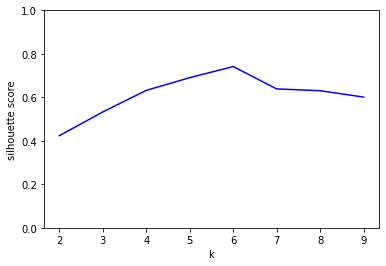

Highest K-Medoids silhouette score: k = 6


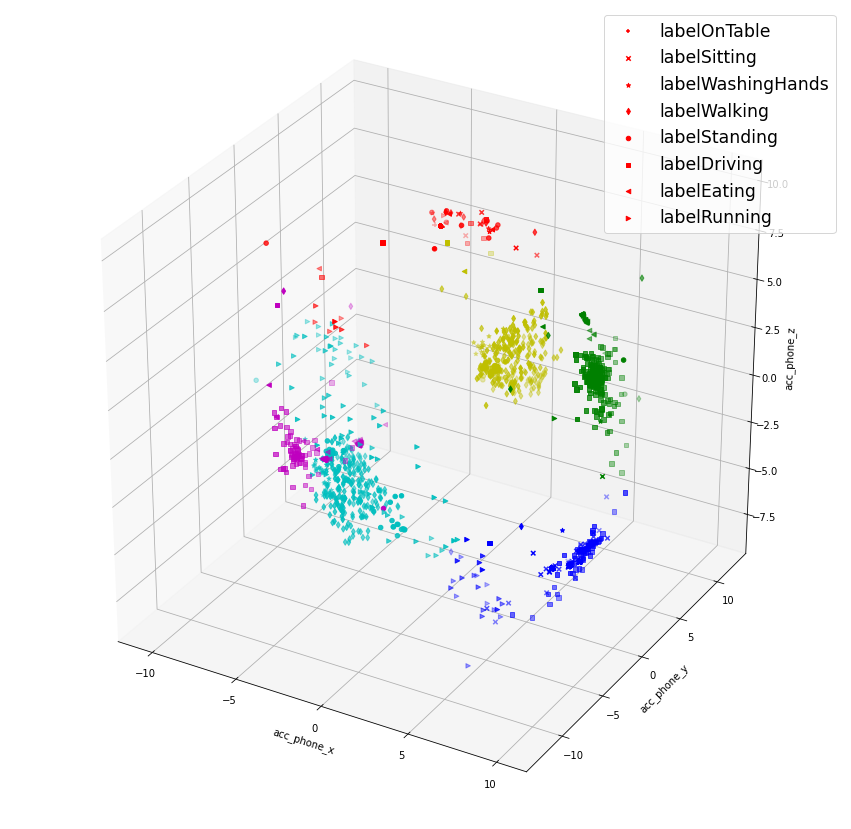

Figure saved to figures/figure_7.png


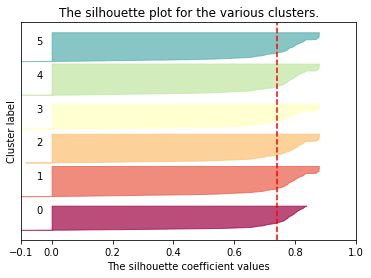

\multirow{2}{*}{ acc_phone_x } & mean  &  -0.31 &  8.24 &  7.97 &  -0.86 &  -8.21 &  -0.56\\
 & std  &  1.06 &  0.96 &  1.01 &  1.62 &  0.94 &  1.21\\
\multirow{2}{*}{ acc_phone_y } & mean  &  1.03 &  0.59 &  -2.46 &  -9.52 &  2.25 &  9.55\\
 & std  &  1.89 &  1.40 &  2.25 &  1.46 &  1.94 &  1.12\\
\multirow{2}{*}{ acc_phone_z } & mean  &  9.26 &  4.53 &  -4.76 &  0.30 &  -4.67 &  -0.56\\
 & std  &  0.87 &  1.38 &  1.08 &  1.54 &  1.44 &  1.62\\
labelOnTable  & percentage  &  99.56 \% &  0.44 \% &  0.00 \% &  0.00 \% &  0.00 \% &  0.00 \%\\
labelSitting  & percentage  &  2.40 \% &  0.40 \% &  97.20 \% &  0.00 \% &  0.00 \% &  0.00 \%\\
labelWashingHands  & percentage  &  7.02 \% &  1.75 \% &  1.75 \% &  56.14 \% &  0.00 \% &  33.33 \%\\
labelWalking  & percentage  &  1.87 \% &  0.94 \% &  0.47 \% &  46.14 \% &  0.47 \% &  50.12 \%\\
labelStanding  & percentage  &  4.74 \% &  1.42 \% &  0.00 \% &  48.34 \% &  0.47 \% &  45.02 \%\\
labelDriving  & percentage  &  1.67 \% &  55.56 \% &  20

In [9]:
k_values = range(2, 10)
silhouette_values = []

# Do some initial runs to determine the right number for k

print('===== k medoids clustering =====')
cols = ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z']
cols = ['acc_phone_x', 'acc_phone_y', 'acc_phone_z']

for k in k_values:
    print(f'k = {k}')
    dataset_cluster = clusteringNH.k_medoids_over_instances(copy.deepcopy(dataset), cols, k, 'default', 20, n_inits=10)
    silhouette_score = dataset_cluster['silhouette'].mean()
    print(f'silhouette = {silhouette_score}')
    silhouette_values.append(silhouette_score)

DataViz.plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score',
                ylim=[0,1], line_styles=['b-'])

# And run k medoids with the highest silhouette score

# k = 6 # todo: replaced with np.argmax call over silhouette scores
k = k_values[np.argmax(silhouette_values)]
print(f'Highest K-Medoids silhouette score: k = {k}')

dataset_kmed = clusteringNH.k_medoids_over_instances(copy.deepcopy(dataset), cols, k, 'default', 20, n_inits=50)
plot_clusters_3d(dataset_kmed, cols, 'cluster', ['label'])
DataViz.plot_silhouette(dataset_kmed, 'cluster', 'silhouette')
util.print_latex_statistics_clusters(dataset_kmed, 'cluster', cols, 'label')

===== k medoids clustering =====
k = 2
silhouette = 0.6689559033160445
k = 3
silhouette = 0.6236776344128234
k = 4
silhouette = 0.6323315801062337
k = 5
silhouette = 0.6269284089373275
k = 6
silhouette = 0.6394857707912178
k = 7
silhouette = 0.6304141525060656
k = 8
silhouette = 0.6006325597259827
k = 9
silhouette = 0.5472952412204631
Figure saved to figures/figure_8.png


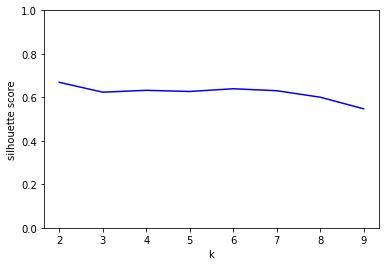

Highest K-Medoids silhouette score: k = 2


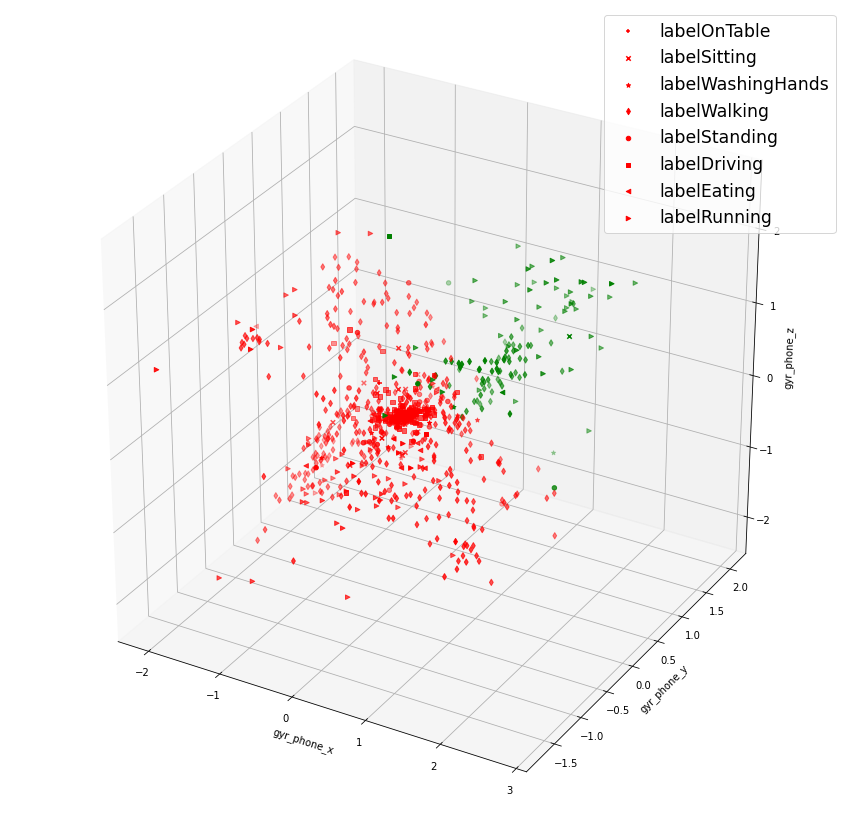

Figure saved to figures/figure_9.png


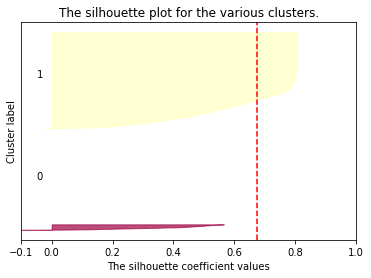

\multirow{2}{*}{ gyr_phone_x } & mean  &  -0.06 &  1.13\\
 & std  &  0.42 &  0.50\\
\multirow{2}{*}{ gyr_phone_y } & mean  &  0.01 &  0.32\\
 & std  &  0.32 &  0.56\\
\multirow{2}{*}{ gyr_phone_z } & mean  &  -0.04 &  0.99\\
 & std  &  0.34 &  0.50\\
labelOnTable  & percentage  &  100.00 \% &  0.00 \%\\
labelSitting  & percentage  &  99.60 \% &  0.40 \%\\
labelWashingHands  & percentage  &  96.49 \% &  3.51 \%\\
labelWalking  & percentage  &  84.54 \% &  15.46 \%\\
labelStanding  & percentage  &  98.58 \% &  1.42 \%\\
labelDriving  & percentage  &  99.72 \% &  0.28 \%\\
labelEating  & percentage  &  99.49 \% &  0.51 \%\\
labelRunning  & percentage  &  55.05 \% &  44.95 \%\\


In [10]:
k_values = range(2, 10)
silhouette_values = []

# Do some initial runs to determine the right number for k

print('===== k medoids clustering =====')
cols = ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z']
# cols = ['acc_phone_x', 'acc_phone_y', 'acc_phone_z']

for k in k_values:
    print(f'k = {k}')
    dataset_cluster = clusteringNH.k_medoids_over_instances(copy.deepcopy(dataset), cols, k, 'default', 20, n_inits=10)
    silhouette_score = dataset_cluster['silhouette'].mean()
    print(f'silhouette = {silhouette_score}')
    silhouette_values.append(silhouette_score)

DataViz.plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score',
                ylim=[0,1], line_styles=['b-'])

# And run k medoids with the highest silhouette score

# k = 6 # todo: replaced with np.argmax call over silhouette scores
k = k_values[np.argmax(silhouette_values)]
print(f'Highest K-Medoids silhouette score: k = {k}')

dataset_kmed = clusteringNH.k_medoids_over_instances(copy.deepcopy(dataset), cols, k, 'default', 20, n_inits=50)
plot_clusters_3d(dataset_kmed, cols, 'cluster', ['label'])
DataViz.plot_silhouette(dataset_kmed, 'cluster', 'silhouette')
util.print_latex_statistics_clusters(dataset_kmed, 'cluster', cols, 'label')

# hierarchical clustering

===== agglomerative clustering =====
k = 2
silhouette = 0.40723374534530976
Figure saved to figures/figure_39.png


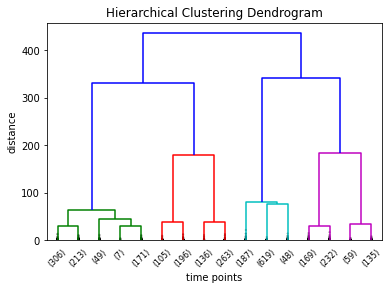

k = 3
silhouette = 0.5019390948206321
Figure saved to figures/figure_40.png


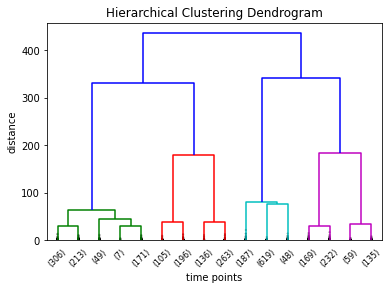

k = 4
silhouette = 0.6345486282226208
Figure saved to figures/figure_41.png


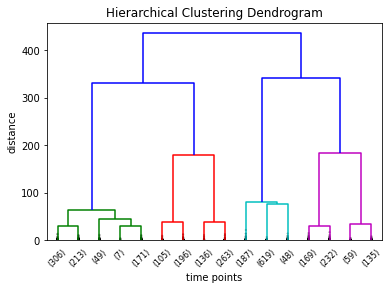

k = 5
silhouette = 0.6788716900628495
Figure saved to figures/figure_42.png


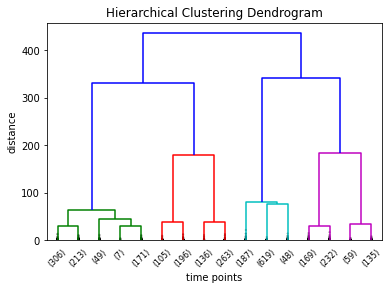

k = 6
silhouette = 0.730042663956915
Figure saved to figures/figure_43.png


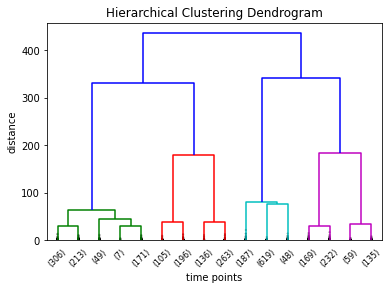

k = 7
silhouette = 0.7203628574989319
Figure saved to figures/figure_44.png


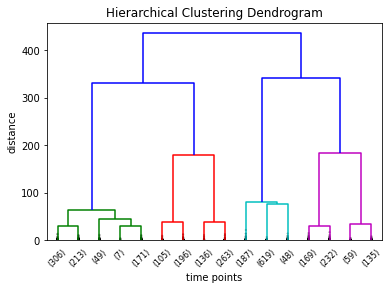

k = 8
silhouette = 0.7293167196858152
Figure saved to figures/figure_45.png


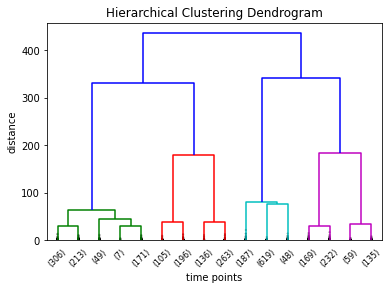

k = 9
silhouette = 0.6604087243164882
Figure saved to figures/figure_46.png


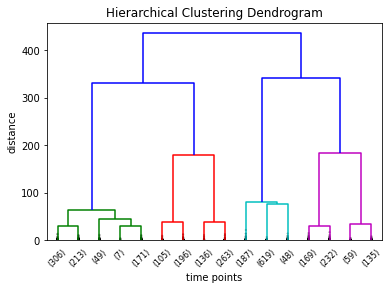

Figure saved to figures/figure_47.png


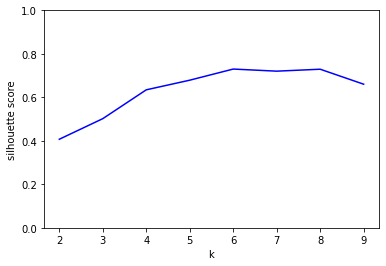

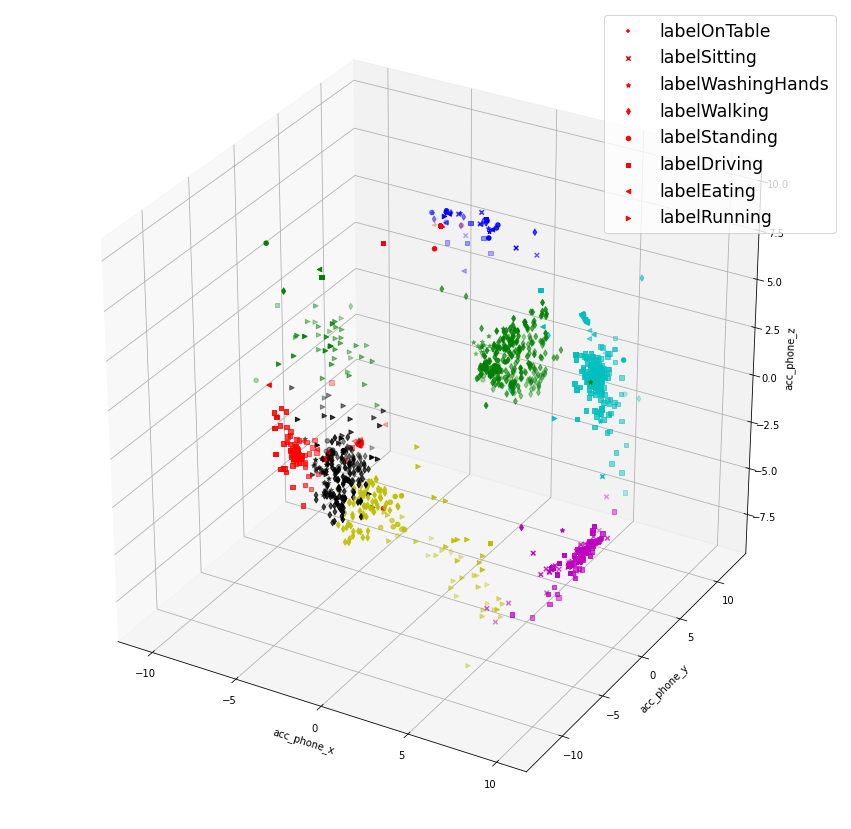

In [15]:
clusteringH = HierarchicalClustering()

k_values = range(2, 10)
silhouette_values = []

# Do some initial runs to determine the right number for the maximum number of clusters.

print('===== agglomerative clustering =====')
# cols = ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z']
cols = ['acc_phone_x', 'acc_phone_y', 'acc_phone_z']

for k in k_values:
    print(f'k = {k}')
    dataset_cluster, l = clusteringH.agglomerative_over_instances(copy.deepcopy(dataset), cols, k, 'euclidean', use_prev_linkage=True, link_function='ward')
    silhouette_score = dataset_cluster['silhouette'].mean()
    print(f'silhouette = {silhouette_score}')
    silhouette_values.append(silhouette_score)

    DataViz.plot_dendrogram(dataset_cluster, l)



DataViz.plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score',
                ylim=[0,1], line_styles=['b-'])


plot_clusters_3d(dataset_cluster, cols, 'cluster', ['label'])


===== agglomerative clustering =====
k = 2
silhouette = 0.6676832244147044
Figure saved to figures/figure_30.png


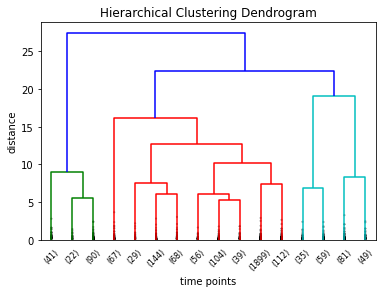

k = 3
silhouette = 0.6623398255090682
Figure saved to figures/figure_31.png


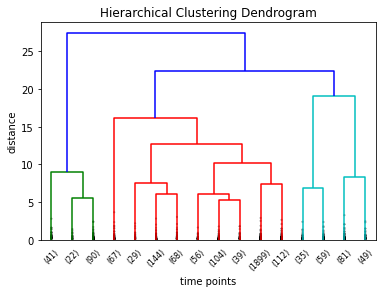

k = 4
silhouette = 0.674432809776737
Figure saved to figures/figure_32.png


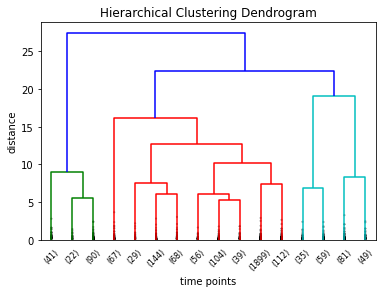

k = 5
silhouette = 0.6855873627560384
Figure saved to figures/figure_33.png


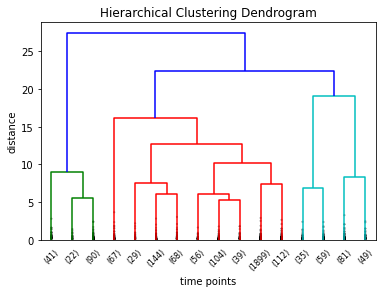

k = 6
silhouette = 0.60381087976861
Figure saved to figures/figure_34.png


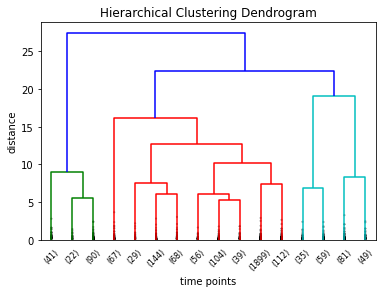

k = 7
silhouette = 0.6002214412293737
Figure saved to figures/figure_35.png


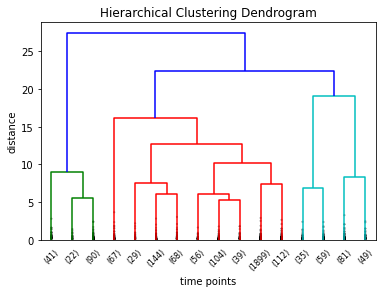

k = 8
silhouette = 0.6002559752038632
Figure saved to figures/figure_36.png


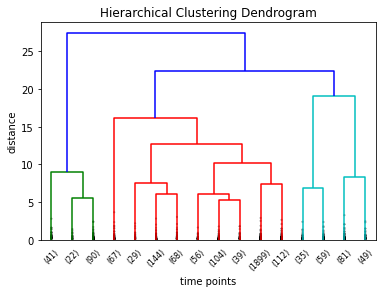

k = 9
silhouette = 0.6003549065297462
Figure saved to figures/figure_37.png


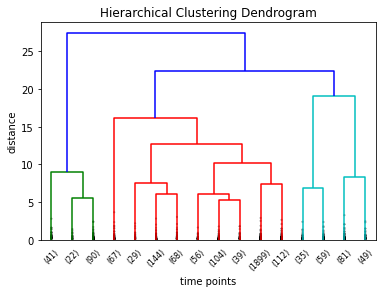

Figure saved to figures/figure_38.png


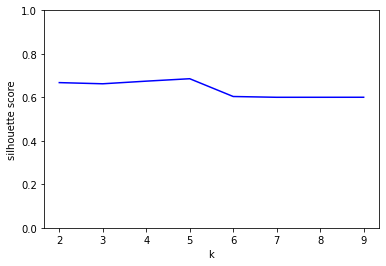

In [14]:
clusteringH = HierarchicalClustering()

k_values = range(2, 10)
silhouette_values = []

# Do some initial runs to determine the right number for the maximum number of clusters.

print('===== agglomerative clustering =====')
cols = ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z']
# cols = ['acc_phone_x', 'acc_phone_y', 'acc_phone_z']

for k in k_values:
    print(f'k = {k}')
    dataset_cluster, l = clusteringH.agglomerative_over_instances(copy.deepcopy(dataset), cols, k, 'euclidean', use_prev_linkage=True, link_function='ward')
    silhouette_score = dataset_cluster['silhouette'].mean()
    print(f'silhouette = {silhouette_score}')
    silhouette_values.append(silhouette_score)

    DataViz.plot_dendrogram(dataset_cluster, l)

DataViz.plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score',
                ylim=[0,1], line_styles=['b-'])

